# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: Simone Marretta

**Matricola**: 1911358

Send the completed notebook before 26/11/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [20]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [21]:
from tensorflow.keras.constraints import NonNeg

class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape):
        #initializer = tf.random_uniform_initializer(minval = 0.1)
        initializer = tf.constant_initializer(value=0.1)
        self.a = self.add_weight(name='alpha',initializer=initializer,shape=[self.units],trainable=True,constraint=NonNeg())
        self.b = self.add_weight(name='beta',initializer=initializer,shape=[self.units],trainable=True,constraint=NonNeg())

    def call(self, inputs):
      return (self.a/self.b)*tf.maximum(0., inputs) + self.a * (tf.exp(tf.minimum(0., inputs)/self.b)-1)

    def get_config(self):
      base_config = super().get_config()
      return {**base_config, "units": self.units}


        


**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [22]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



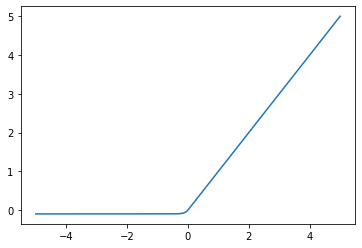

In [23]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]


y_range = pelu(x_range)

plt.plot(x_range.numpy(), y_range.numpy())

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [24]:
#Gradients with autograd
x = tf.cast(tf.linspace(-5, 5, 200), tf.float32)
with tf.GradientTape() as t:
  t.watch(x)
  y = pelu(x)
auto_grads = t.jacobian(y,pelu.trainable_variables[0])
auto_grads = tf.reshape(auto_grads, [-1])



In [25]:
#Manual gradients

a = pelu.trainable_variables[0]
b = pelu.trainable_variables[1]
manual_grads = (1/b)*tf.maximum(0., x) + (tf.exp(tf.minimum(0., x)/b)-1)
tf.reduce_all(tf.abs(manual_grads - auto_grads) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [26]:
#Same procedure for beta
x = tf.cast(tf.linspace(-5, 5, 200), tf.float32)
with tf.GradientTape() as t:
  t.watch(x)
  y = pelu(x)
auto_grads_b = t.jacobian(y,pelu.trainable_variables[1])
auto_grads_b = tf.reshape(auto_grads_b, [-1])

In [27]:
#Manual gradients

manual_grads_b = (-a/tf.pow(b, 2))*tf.maximum(0., x) + (-a/tf.pow(b, 2))*tf.minimum(0., x)*(tf.exp(tf.minimum(0., x)/b))
                 
tf.reduce_all(tf.abs(manual_grads_b - auto_grads_b) < 1e-4)


<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

In [28]:
#Importing the dataset using tensorflow datasets
import tensorflow_datasets as tfds
from tensorflow import keras
#We'll use the fashion-mnist dataset

#Loading the dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#preprocessing the data
train_images = train_images / 255.0
test_images = test_images / 255.0



In [29]:
model = tf.keras.Sequential(layers=[
      #We added an addition layer to flatten pixels                             
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                39250     
_________________________________________________________________
pelu_3 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 39,860
Trainable params: 39,860
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [31]:
#We train our model

model.fit(train_images, train_labels, epochs=30)


Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5079 - accuracy: 0.8206
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3813 - accuracy: 0.8625
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3473 - accuracy: 0.8746
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3264 - accuracy: 0.8808
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3123 - accuracy: 0.8854
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2989 - accuracy: 0.8888
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2900 - accuracy: 0.8925
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2795 - accuracy: 0.8964
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2702 - accuracy: 0.9000
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.265

In [32]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

print('\nTest accuracy:', test_acc)


313/313 [==============================] - 1s 2ms/step - loss: 0.3978 - accuracy: 0.8833

Test accuracy: 0.8833000063896179


In [33]:
#We do the same but this time we use a standard Relu activation function

model_relu = tf.keras.Sequential(layers=[
      #We added an addition layer to flatten pixels                             
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(50),
      tf.keras.layers.ReLU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])
model_relu.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                39250     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_relu.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [35]:
#We train our model

model_relu.fit(train_images, train_labels, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5296 - accuracy: 0.8161
Epoch 2/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4023 - accuracy: 0.8575
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3599 - accuracy: 0.8713
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3380 - accuracy: 0.8769
Epoch 5/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3195 - accuracy: 0.8838
Epoch 6/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3074 - accuracy: 0.8869
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2950 - accuracy: 0.8911
Epoch 8/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2832 - accuracy: 0.8950
Epoch 9/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2766 - accuracy: 0.8975
Epoch 10/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.269

In [36]:
test_loss, test_acc = model_relu.evaluate(test_images,  test_labels)

print('\nTest accuracy:', test_acc)

#We see that the accuracy is slighter less.This result is consistent with the PELU paper.

313/313 [==============================] - 1s 2ms/step - loss: 0.3939 - accuracy: 0.8793

Test accuracy: 0.8792999982833862


**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [37]:
model.save('pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('pelu_model')

INFO:tensorflow:Assets written to: pelu_model/assets


In [38]:
print("Original model:", model)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

Original model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc6fa1eda58>
Loaded model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc6f234e9e8>


### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.